# T-AMSOS : Simulation Analysis

In [68]:
import os, math, random, shutil, yaml, glob, copy, random, sys,time
import numpy as np
from pytransform3d import rotations as pyro
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
from scipy.optimize import curve_fit

In [106]:
# tactoid sim path
vpath = "/Users/saadjansari/Documents/Projects/AMSOS/resultsSummit/validation_rotdif_tao"

files = {
    '250': 'N_250',
    '500': 'N_500',
    '1000': 'N_1000',
    '1500': 'N_1500',
}
dt = 0.005
D_rod = 23.7 # s^-1

# Specify parameters
run_visualization = True
run_tests = False

plt.close('all')

### Utility Functions:
#### Filament and Protein class:

In [7]:
# Filament class
class Filament():
    def __init__(self, pos0, pos1, radius,gid):
        self.radius = radius
        self.pos0 = pos0
        self.pos1 = pos1
        self.gid = gid
    def GetCenter(self,boxsize):
        return getMean(self.pos0, self.pos1,boxsize)
    def GetLength(self,boxsize):
        xi = getDistance(self.pos1,self.pos0,boxsize)
        return np.linalg.norm( xi)
    def GetOrientation(self):
        xi = self.pos1 - self.pos0
        return xi/np.sqrt(xi.dot(xi))

    def Plot3(self,ax, col="red"):
        ax.plot3D( [self.pos0[0], self.pos1[0]], [self.pos0[1], self.pos1[1]], [self.pos0[2], self.pos1[2]], col)
    def GetStringtoWrite(self):
        return 'C {0} {1} {2:0.6f} {3:0.6f} {4:0.6f} {5:0.6f} {6:0.6f} {7:0.6f}\n'.format(
        self.gid, self.radius,
        self.pos0[0], self.pos0[1], self.pos0[2],
        self.pos1[0], self.pos1[1], self.pos1[2])
    def __repr__(self):
        return "Filament()"
    def __str__(self):
        return 'Filament {0}:\n  pos0: {1}\n  pos1: {2}\n  radius: {3}'.format(self.gid, self.pos0, self.pos1,self.radius)

#### Nearest image convention:
Distance and Mean calculation functions that use the nearest image convention.

In [8]:
def getDistance(p0,p1,boxsize):
    # distance between two points in the nearest image convention
    # can use multidimensional arrays for distances between multiple points
    dist = np.absolute( p1-p0)
    for idx in range(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            dist[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            dist[:,idx] -= k*boxsize[idx]
        elif len(dist.shape) == 3:
            k = np.floor( dist[:,:,idx]/(0.5*boxsize[idx]))
            dist[:,:,idx] -= k*boxsize[idx]
    return np.absolute(dist)
def getMean(p0,p1,boxsize):
    # mean of the two points in the nearest image
    dist = np.absolute(p1-p0)
    for idx in range(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            p1[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            p1[:,idx] -= k*boxsize[idx]
        elif len(dist.shape) == 3:
            k = np.floor( dist[:,:,idx]/(0.5*boxsize[idx]))
            p1[:,:,idx] -= k*boxsize[idx]
    return (p0 + p1)/2

In [108]:
def get_rot_cor( ftlist):
    nF = len( ftlist[0])
    nT = len(ftlist)
    datInit = np.zeros( (nF,3))
    # get initial orientations
    for ifil, fil in enumerate( ftlist[0]):
        datInit[ifil,:] = fil.GetOrientation()
    
    # Get all orientations
    rcor = np.zeros(nT)
    rcor_std = np.zeros(nT)
    for it in range(nT):
        datT = np.zeros( (nF, 3))
        for ifil, fil in enumerate( ftlist[it]):
            datT[ifil,:] = fil.GetOrientation()
        
        dff = np.sum(datT*datInit, axis=1)
        #lgdre = 0.5*( 3*dff**2 -1)
        lgdre = dff
        rcor[it] = np.mean( lgdre )
        rcor_std[it] = np.std( lgdre)
        
    return rcor, rcor_std

# Get key to sort through file indices
def fileKey(f):
    k = int(f[f.rfind("_")+1:f.rfind(".")])
    return k
def exp_func_1(x, a):
    return 1 * np.exp(-6* a * x) + 0
def exp_func_2(x, a):
    return 1 * np.exp(-2* a * x) + 0

In [109]:
def load_sim(pth):
    # find filament files
    files = glob.glob( os.path.join(pth, 'result/result*/SylinderAscii_*.dat'))
    files = sorted(files, key=fileKey)
    ftlist = []
    for fil in files:
        flist = []
        with open(fil, 'r') as file1:
            for line in file1:
                if line.startswith('C'):
                    data = line.split()
                    gid = int(data[1])
                    radius = float(data[2])
                    pos0 = np.array([float(data[3]), float(data[4]), float(data[5])])
                    pos1 = np.array([float(data[6]), float(data[7]), float(data[8])])
                    flist.append( Filament(pos0, pos1, radius,gid))
        ftlist.append(flist)

    # Toss out zeroth timestep
    ftlist.pop(0)
    nT = len(ftlist)
    nF = len(ftlist[0])
    print('Simulation details:\n  Filaments: {0}\n  Frames: {1}'.format(nF,nT))
    return ftlist

### SCRIPT:

<IPython.core.display.Javascript object>


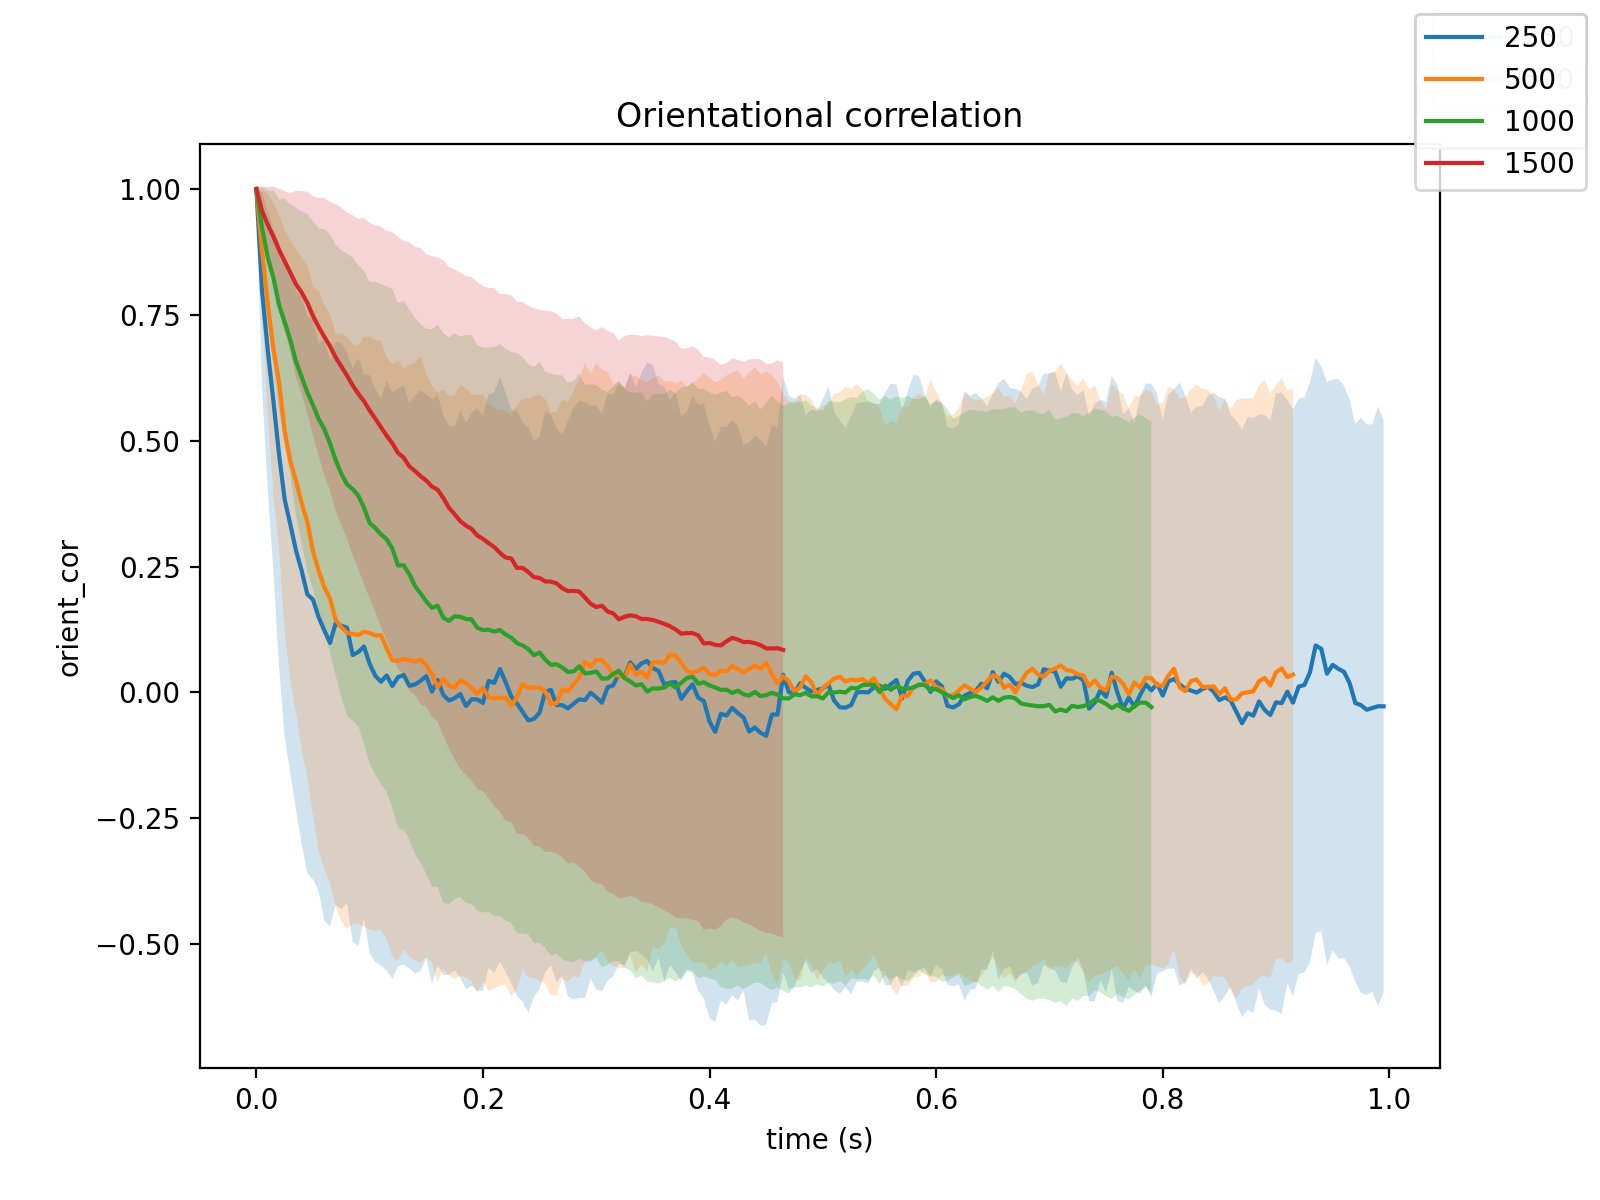

Simulation details:
  Filaments: 250
  Frames: 200
D_r = 17.390391511436636
Simulation details:
  Filaments: 500
  Frames: 184
D_r = 12.333735791699448
Simulation details:
  Filaments: 1000
  Frames: 159
D_r = 5.4485999361938395
Simulation details:
  Filaments: 1500
  Frames: 94
D_r = 2.9021347907291943


In [110]:
dif_coefs = []
dif_coefs_sig = []
pfs = []
for key in files.keys():
    pfs.append( int(key))
fig, ax = plt.subplots( figsize=(8,6))
for key in files.keys():
    ftlist = load_sim( os.path.join(vpath, files[key]) )
    
    nF = len( ftlist[0])
    nT = len(ftlist)
    
    mu, sig = get_rot_cor( ftlist)
    
    # fit exponential
    popt, pcov = curve_fit(exp_func_2, dt*np.arange(nT), mu)
    print('D_r = {0}'.format(popt[0]))
    dif_coefs.append( popt[0] / D_rod)
    dif_coefs_sig.append( np.sqrt(pcov[0,0]) / D_rod)

    ax.plot( dt*np.arange(nT), mu, label=key)
    ax.fill_between( dt*np.arange(nT), mu-sig, mu+sig, alpha=0.2)
    ax.set(xlabel='time (s)', ylabel='orient_cor', title='Orientational correlation')
    fig.legend()

<IPython.core.display.Javascript object>


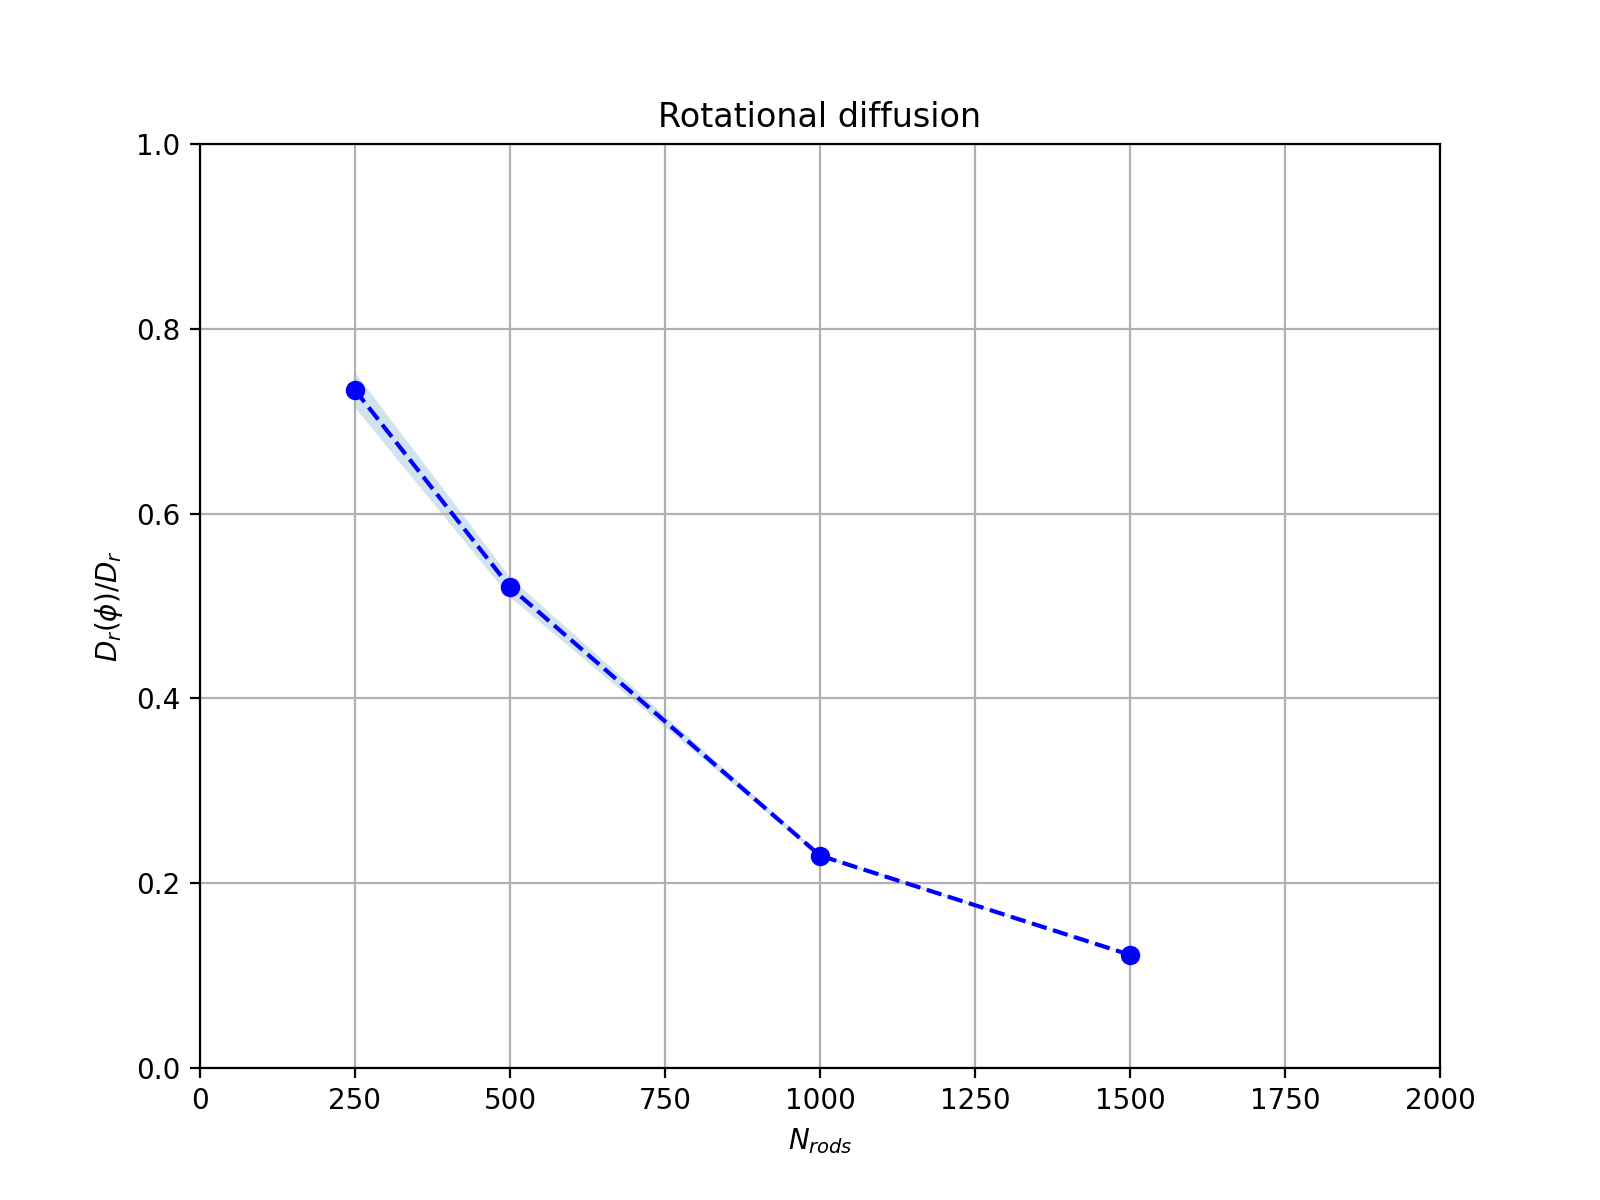

In [111]:
fig, ax = plt.subplots( figsize=(8,6))
ax.plot( np.array(pfs), np.array(dif_coefs), '--bo')
ax.fill_between( np.array(pfs), np.array(dif_coefs)-np.array(dif_coefs_sig), np.array(dif_coefs)+np.array(dif_coefs_sig), alpha=0.2)
ax.set(xlabel='$N_{rods}$', ylabel='$D_r (\phi) / D_r$', title='Rotational diffusion')
ax.set(xlim=[0,2000], ylim=[0,1])
plt.grid()